# *contents*

- preparation: load and merge dataframes
- naive strategy: uses all in-sample data to fit one Total Least Squares (or PCA) model
- sliding window TLS

In [1]:
%matplotlib inline
import logging
import collections
import time
import pprint
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helper
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo_code, datainfo_abbr = helper.datafiles_info_v2()
#datainfo_code

In [3]:
def build_big_df():
    sw = helper.StopWatch()
    series = []
    keys   = []
    for di in datainfo_code.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        #logging.info('{} {} {}'.format(di.code, di.name, df.shape))
        series.append(df.close)
        keys.append(di.code)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}, time cost: {:.3f} sec'.format(df.shape, sw.elapse_time()))
    return df

huge_df = build_big_df()
huge_df.describe()

[2023-05-03 12:19:27,504] [INFO]	[3293873969.py:11:build_big_df] result df shape: (5410, 18), time cost: 7.229 sec


,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ,300750.SZ,300760.SZ,300059.SZ,300124.SZ,600519.SH,000858.SZ,000568.SZ,600809.SH,002304.SZ
count,4420.000000,2655.000000,2459.000000,2763.000000,1643.000000,594.000000,2372.000000,440.000000,357.000000,1185.000000,1101.000000,3120.000000,3035.000000,5182.000000,5275.000000,5298.000000,5357.000000,3262.000000
mean,2.017500,3.362446,5.382457,1.852079,0.898278,1.269764,3.053285,0.712639,0.865006,155.229266,281.180995,6.883751,22.692494,427.207998,51.576161,46.900142,46.776145,85.581907
std,0.762775,0.931155,1.199667,0.704466,0.303249,0.198064,0.584696,0.120683,0.070014,103.841653,101.208698,6.916949,21.835922,612.508235,70.949160,66.579176,85.714338,48.884643
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000,19.871648,68.250304,0.224905,2.681423,3.914016,2.443769,1.370304,1.510593,20.158486
25%,1.446302,2.777259,4.621834,1.356000,0.658000,1.078000,2.616000,0.616000,0.811000,44.810017,180.379435,0.902151,8.074883,58.181431,7.375643,5.582244,3.670246,49.367024
50%,1.983732,3.428157,5.610480,1.761000,0.814000,1.267500,2.774000,0.663500,0.851000,138.171262,306.500000,5.052485,14.481520,127.285914,22.568334,22.435865,13.068389,70.378281
75%,2.656780,3.953988,6.175000,2.354500,1.114000,1.432500,3.653000,0.843000,0.907000,241.142719,341.225268,8.873279,21.596514,568.686743,51.764661,44.201286,26.877031,111.620037
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.378000,0.994000,1.036000,379.149090,490.225738,26.761412,87.180843,2549.222392,335.942243,305.769613,372.042113,255.225037


In [4]:
if 0:
    etf_df = huge_df[huge_df.columns[:9]].copy()
    etf_df.rename(columns=dict(
        [ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo_code.values() ]), inplace=True)
    etf_df.plot(figsize=(10,7), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

In [5]:
def slice_pair(huge_df, abbr1, abbr2):
    info1 = datainfo_abbr[abbr1.upper()]
    info2 = datainfo_abbr[abbr2.upper()]
    slice_df = huge_df[[info1.code, info2.code]].copy()
    slice_df.dropna(axis=0, inplace=True)
    slice_df.rename(
        columns=dict(
            [(info1.code, info1.abbr), (info2.code, info2.abbr)]
        ), inplace=True)
    return slice_df

def plot_pair_price(pair):
    x = pair.iloc[:, 0]
    y = pair.iloc[:, 1]
    x_info = datainfo_abbr[pair.columns[0]]
    y_info = datainfo_abbr[pair.columns[1]]

    model  = sm.OLS(y, sm.add_constant(x))
    result = model.fit()
    print(result.summary())

    first_ymd = pair.index[0].strftime('%Y-%m-%d')
    last_ymd  = pair.index[-1].strftime('%Y-%m-%d')

    span = x.max() - x.min()
    x2 = np.linspace(x.min(), x.max(),
                     np.maximum(pair.shape[0] // 10, 500))
    y2 = result.params[0] + x2 * result.params[1]

    plt.figure(figsize=(8, 5), dpi=120)
    plt.scatter(x, y, marker='.', color='tab:blue')
    regress_title = 'OLS: $y = {:.2f} {:+.2f} \cdot x$'.format(*result.params)
    plt.plot(x2, y2, label=regress_title, color='tab:orange')
    plt.xlabel('{} {}'.format(x_info.code, x_info.name))
    plt.ylabel('{} {}'.format(y_info.code, y_info.name))
    plt.title('close price [{}, {}]'.format(first_ymd, last_ymd))
    plt.legend(loc='best')

# *Fit a linear model (beta) for each rolling window*

**TODO**: use EWMA instread of MA

In [6]:
def calculate_spread_info(dataframe, window=20, first_date='', last_date=''):
    if first_date and last_date:
        df = dataframe[first_date:last_date]
    elif first_date and not last_date:
        df = dataframe[first_date:]
    elif not first_date and last_date:
        df = dataframe[:last_date]
    else:
        df = dataframe
    x_name, y_name = df.columns
    result_df = (df - df.shift()).dropna(axis=0)

    def calculate_beta(win_series):
        # this is a hack!
        df_idx = win_series.index
        model  = sm.OLS(result_df[y_name].loc[df_idx], result_df[x_name].loc[df_idx])
        model_info = model.fit()
        return model_info.params[0]
    # rolling().apply(): to either x_name or y_name is ok
    result_df['beta'] = result_df[x_name].rolling(window=window).apply(calculate_beta, raw=False)
    result_df.rename(columns=dict([
        (x_name, '{}_diff'.format(x_name)),
        (y_name, '{}_diff'.format(y_name)),
    ]), inplace=True)
    result_df['spread']      = df[y_name] - result_df['beta'].shift(1) * df[x_name]
    result_df['spread_mean'] = result_df['spread'].shift().rolling(window=window).mean()
    result_df['spread_dev']  = result_df['spread'].shift().rolling(window=window).std()

    return pd.merge(df, result_df, left_index=True, right_index=True)

In [7]:
# pair_df = slice_pair(huge_df, 'wly', 'gzmt')
# pair_df = slice_pair(huge_df, 'cybetf', 'ndsd')
# pair_df = slice_pair(huge_df, 'cyb50etf', 'ndsd')
k_window   = 60
pair_df    = slice_pair(huge_df, 'lzlj', 'gzmt')
sw = helper.StopWatch()
result_df  = calculate_spread_info(pair_df, window=k_window)
logging.info('time cost: {:.3f} sec'.format(sw.elapse_time()))
logging.info('date range [{}, {}]'.format(
    result_df.index[0].strftime('%Y-%m-%d'), result_df.index[-1].strftime('%Y-%m-%d')))

[2023-05-03 12:19:35,396] [INFO]	[1042465476.py:8:<module>] time cost: 7.700 sec
[2023-05-03 12:19:35,412] [INFO]	[1042465476.py:9:<module>] date range [2001-08-28, 2023-04-25]


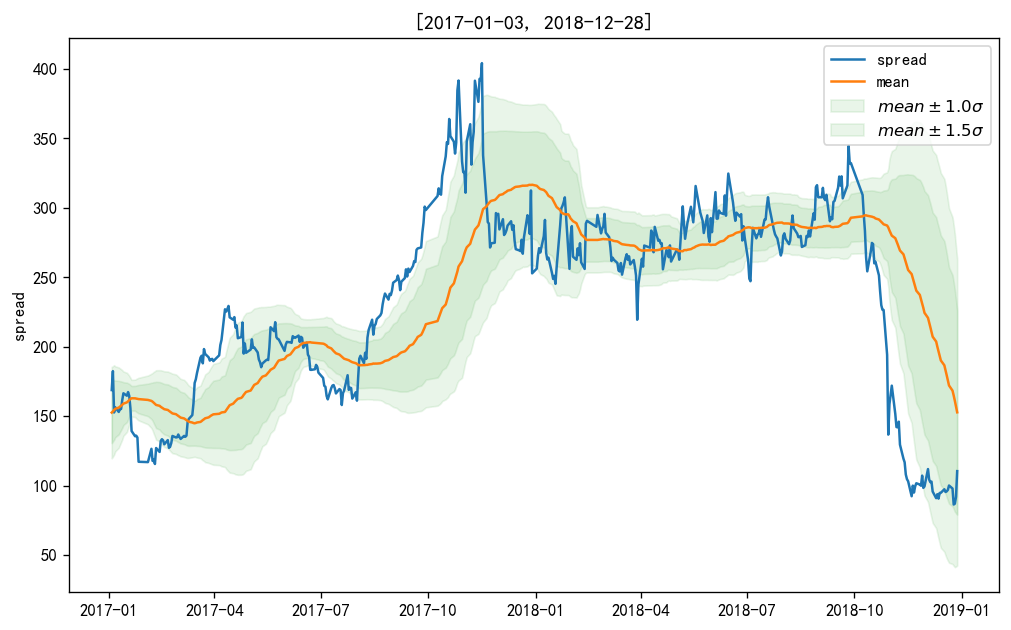

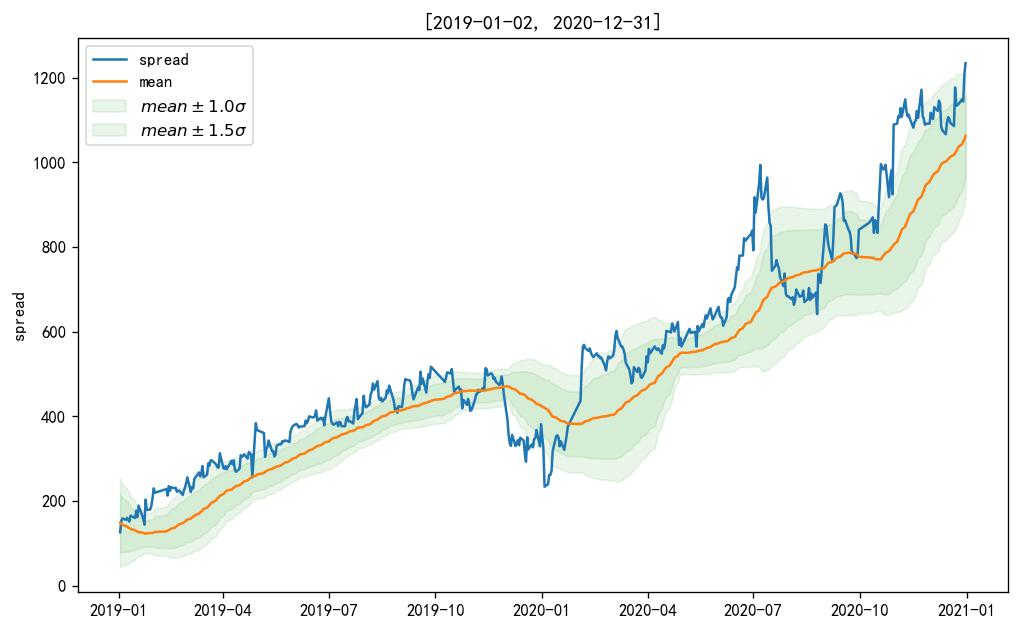

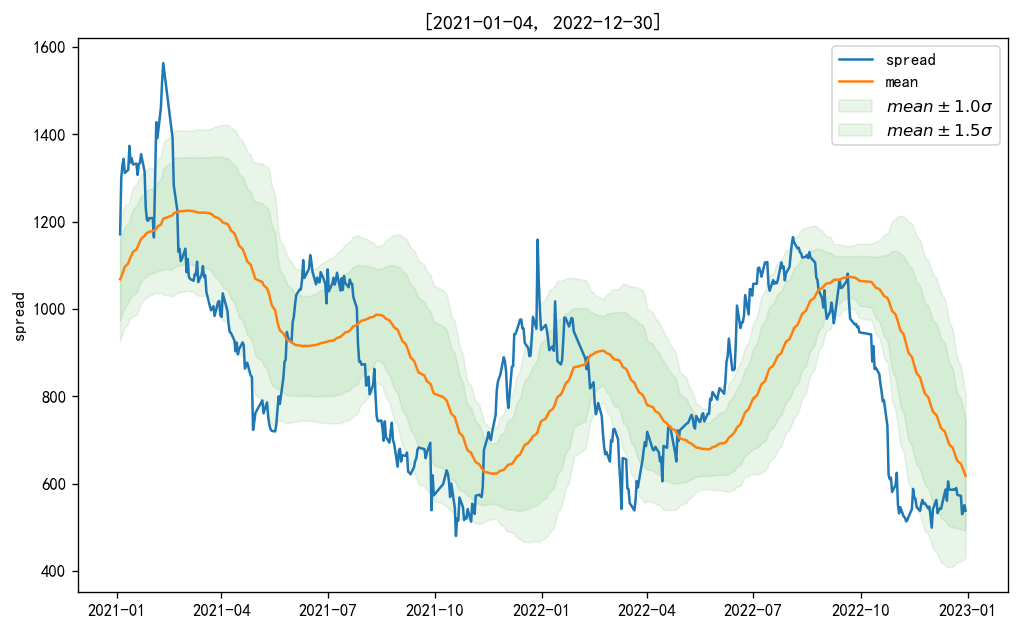

In [8]:
def plot_strategy(data_df):
    first_ymd = data_df.index[0].strftime('%Y-%m-%d')
    last_ymd  = data_df.index[-1].strftime('%Y-%m-%d')

    plt.figure(figsize=(10,6), dpi=120)
    plt.plot(data_df.spread, label='spread')
    plt.plot(data_df.spread_mean, label='mean', color='tab:orange')
    ka, kb = 1.0, 1.5
    ca, cb = 'tab:green', 'tab:green'
    plt.fill_between(data_df.spread.index,
                     data_df.spread_mean - ka * data_df.spread_dev,
                     data_df.spread_mean + ka * data_df.spread_dev,
                     color=ca, alpha=0.10, label='$mean\pm {}\sigma$'.format(ka))
    plt.fill_between(data_df.spread.index,
                     data_df.spread_mean - kb * data_df.spread_dev,
                     data_df.spread_mean + kb * data_df.spread_dev,
                     color=cb, alpha=0.10, label='$mean\pm {}\sigma$'.format(kb))
    
    # plt.plot(result_df.spread_mean + result_df.spread_dev, label='$\sigma$', color='tab:orange')
    # plt.plot(result_df.spread_mean - result_df.spread_dev, label='$\sigma$', color='tab:orange')
    plt.legend(loc='best')
    plt.ylabel('spread')
    plt.title('[{}, {}]'.format(first_ymd, last_ymd))

for year in range(2017, 2022, 2):
    year2 = year + 1
    plot_strategy(result_df[str(year):str(year2)])